# Finanace Data Collection

We Will Extract Apple Stock Price Using Following Code:

In [1]:
import pandas as pd
import datetime
from pandas_datareader import data
from pandas import DataFrame, Series

In [3]:
apple_df = data.DataReader("AAPL", "yahoo", start='2004', end='2019') 

In [4]:
apple_df.tail()
#returns last 5 rows from a dataset

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-24,151.550003,146.589996,148.149994,146.830002,37169200.0,145.642090
2018-12-26,157.229996,146.720001,148.300003,157.169998,58582500.0,155.898438
2018-12-27,156.770004,150.070007,155.839996,156.149994,53117100.0,154.886688
2018-12-28,158.520004,154.550003,157.500000,156.229996,42291400.0,154.966034
2018-12-31,159.360001,156.479996,158.529999,157.740005,35003500.0,156.463837


# Data Analysis

### Exploring Rolling Mean and Return Rate of Stocks

#### Rolling Mean (Moving Average) — to determine trend

In [5]:
close_px = apple_df['Adj Close']
mavg = close_px.rolling(window=100).mean()

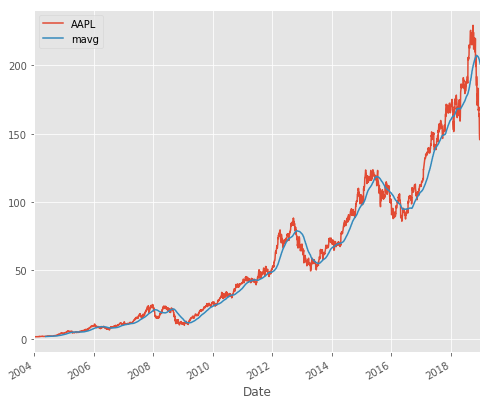

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

#### Return Deviation — to determine risk and return

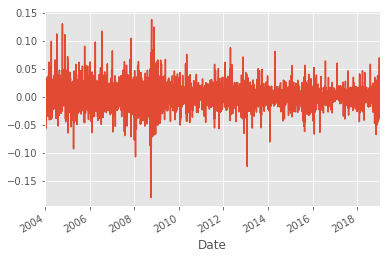

In [7]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

### Analysing your Competitors Stocks

In [8]:
dfcomp = data.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start='2004',end='2019')['Adj Close']

In [9]:
dfcomp[:5] # returns first 5 rows

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2003-12-31,1.337196,17.695911,NaN,64.046783,17.884235
2004-01-02,1.331564,17.775873,NaN,63.265926,17.936493
2004-01-05,1.387254,18.038628,NaN,64.302460,18.387360
2004-01-06,1.382249,17.918674,NaN,64.309410,18.452700
2004-01-07,1.413535,18.095753,NaN,64.115913,18.433098


In [10]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()

In [11]:
corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.377267,0.464320,0.420907,0.426277
GE,0.377267,1.000000,0.367832,0.485622,0.421139
GOOG,0.464320,0.367832,1.000000,0.395965,0.481677
IBM,0.420907,0.485622,0.395965,1.000000,0.519755
MSFT,0.426277,0.421139,0.481677,0.519755,1.000000


Text(0,0.5,'Returns GE')

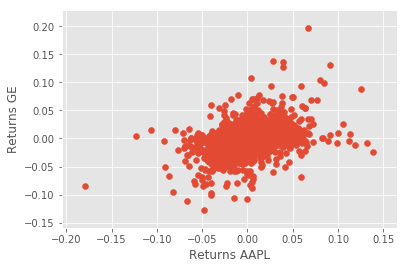

In [12]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

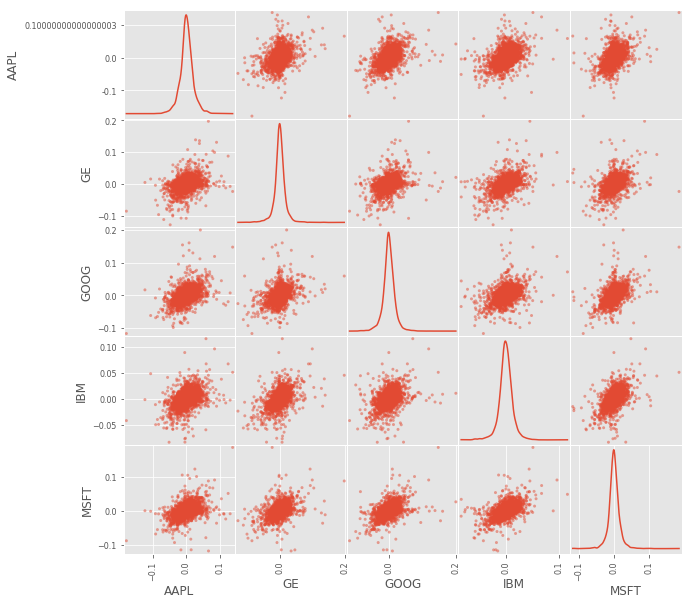

In [13]:
from pandas.plotting import scatter_matrix
scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

HEAT MAP

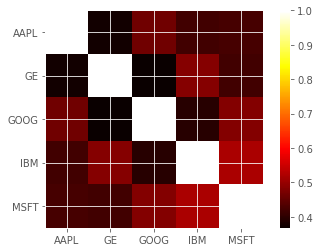

In [14]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

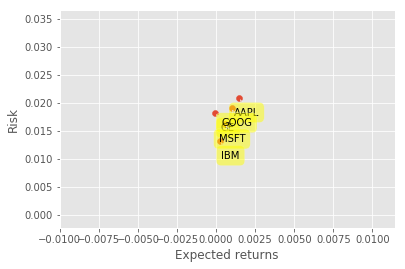

In [15]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(label, xy = (x, y), xytext = (20, -20),textcoords = 'offset points', ha = 'right', va = 'bottom',bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

#### Data Preprocessing and Validation

In [16]:
dfreg = apple_df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (apple_df['High'] - apple_df['Low']) / apple_df['Close'] * 100.0
dfreg['PCT_change'] = (apple_df['Close'] - apple_df['Open']) / apple_df['Open'] * 100.0

In [17]:
import numpy as np
import math
from sklearn import preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

c:\users\samaresh yadav\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

### Prdicting Stock Price

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [21]:
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [22]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
classifiers=[confidencereg,confidencepoly2,confidencepoly3,confidenceknn]

In [25]:
print(confidencereg)
print(confidencepoly2)
print(confidencepoly3)
print(confidenceknn)

0.9756746412649033
0.9784950957639215
0.9804020198658304
0.9734897048145835


In [26]:
#FORECASTING STOCK PRICE

In [23]:
forecast_set=clfknn.predict(X_lately)

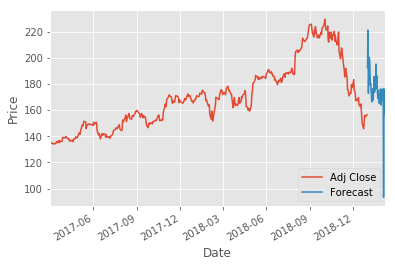

In [24]:
dfreg['Forecast'] = np.nan
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()